In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
siglist = [ (700,300), (1000,300), (1000,450), (1200,500) ]
module = fc.eightb.preselection.ranked_quadh
get_fn = lambda module, mx, my: getattr(module, f"NMSSM_XYY_YToHH_8b_MX_{mx}_MY_{my}")
# signal = ObjIter([ Tree(get_fn(module, mx, my), use_gen=False) for mx, my in siglist])
signal = ObjIter([ Tree(sig, use_gen=False) for sig in module.signal_list])
for s in signal: s.color=None

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


In [4]:
# bkg = ObjIter([ Tree(module.QCD_B_List, use_gen=False),Tree(module.TTJets, use_gen=False) ])
bkg = ObjIter([])

In [5]:
def ak_rank(array, axis=-1, descending=False):
  argsort = ak.argsort( (-1)**descending * array, axis=axis )
  return ak.argsort(argsort, axis=axis)

In [6]:
t8btag = CollectionFilter('jet', 'jet', filter=lambda t: ak_rank(t.jet_btag, descending=True) < 8)

signal = signal.apply(t8btag)

In [7]:
features = ['jet_ptRegressed','jet_mRegressed','jet_eta','jet_phi']
features = {
  feature: ak.std(getattr(signal, feature).cat)
  for feature in features
}
features

{'jet_ptRegressed': 87.67817689499257,
 'jet_mRegressed': 13.16257772094405,
 'jet_eta': 1.035421877791819,
 'jet_phi': 1.8160566147001593}

In [8]:
def normalize_features(t):
  t.extend(
    **{
      feature.replace('jet','norm'):t[feature]/std
      for feature, std in features.items()
    }
  )
signal.apply(normalize_features)

[None, None, None, None, None, None, None, None]

In [9]:
class jet_knn(ObjTransform):
  def init(self):
    self.bins = np.arange(6)
    self.xlabel = f"N Higgs in {self.k}-nn {str(self.features)}"
  def __call__(self, t):
    features = t[self.features]
    pairwise_d2 = None
    for array in ak.unzip(features):
      d2 = (array - array[:,None])**2
      if pairwise_d2 is None: pairwise_d2 = d2
      else: pairwise_d2 = pairwise_d2 + d2
    idx = ak.argsort(pairwise_d2, axis=-1)[:,:,1:self.k+1]

    Id = (t.jet_signalId+2)//2

    j1_Id, j2_Id = ak.unzip(ak.combinations(Id, 2))
    n_total = ak.sum( (j1_Id)*(j1_Id == j2_Id) > 0,axis=-1 )
    Id = Id*(Id == Id[:,None])
    n_paired = ak.sum(ak.sum(Id[idx] > 0,axis=-1),axis=-1)/2
    return 4*(n_paired/n_total)

100%|██████████| 4/4 [00:16<00:00,  4.07s/it]


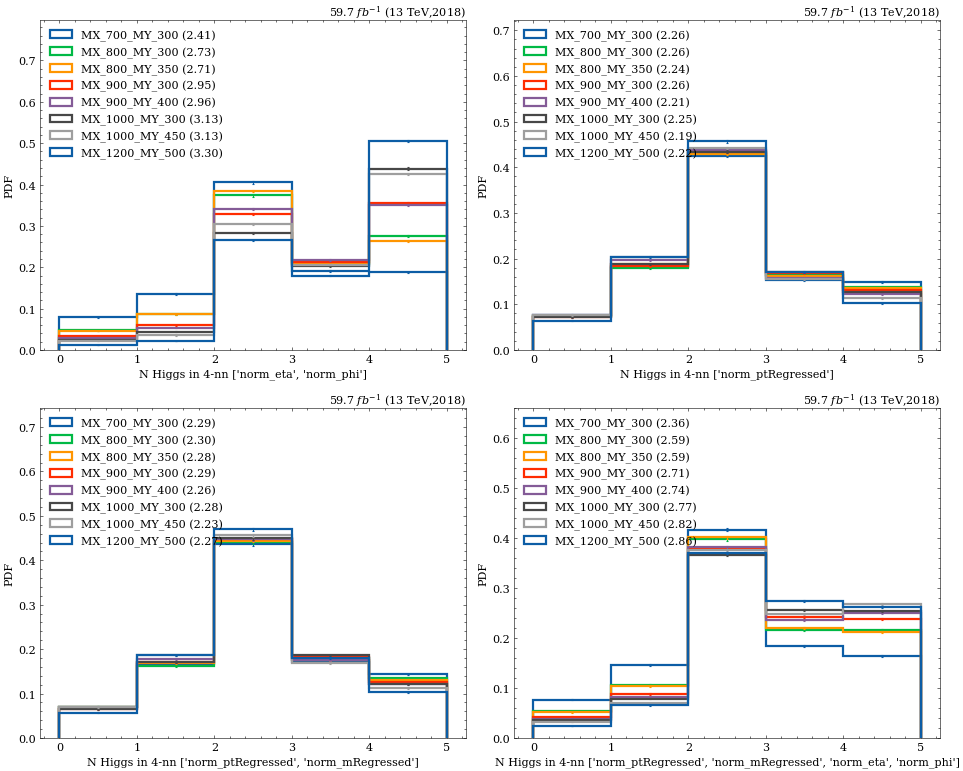

In [13]:
study.quick(
  signal, efficiency=True,
  h_label_stat="{stats.mean:0.2f}", legend=True,
  varlist=[
    jet_knn(k=4, features=['norm_eta','norm_phi']),
    jet_knn(k=4, features=['norm_ptRegressed']),
    jet_knn(k=4, features=['norm_ptRegressed','norm_mRegressed']),
    jet_knn(k=4, features=['norm_ptRegressed','norm_mRegressed','norm_eta','norm_phi']),
    ],
  # binlist=[np.arange(6)]
)